In [1]:
import re

import numpy as np
import pandas as pd

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from baseline.config import STOP_WORDS

In [2]:
# Load PR Newswire Annotated Dataset
pr_newswire = pd.read_csv("../data/pr-newswire.csv")

In [3]:
def text_cleaning(text: str):
    """Cleans raw text input for Doc2Vec."""
    ps = PorterStemmer()
    
    # Strip punctuation and special chars
    stripped = re.sub(r"[^\w]", " ", text)
    
    # Tokenize and stem words
    tokenized = [
        ps.stem(token.lower()) for token in stripped.split(" ")
        if token.strip() and token.lower() not in STOP_WORDS
    ]
    
    return tokenized

In [4]:
raw_news_stories = pr_newswire["data"]

# Establish data and target for vectorization
stories = list(map(text_cleaning, raw_news_stories))
classifications = list(pr_newswire["target"])

In [5]:
# Build Doc2Vec `TaggedDocument` array
documents = [
    TaggedDocument(story, classifications[idx]) for idx, story in enumerate(stories)
]

In [6]:
# Build Doc2Vec model
d2v = Doc2Vec(vector_size=40, min_count=2, epochs=30)
# Build vocabulary
d2v.build_vocab(documents)

In [7]:
# Train doc2vec
d2v.train(documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [8]:
# Destructure words and tags from TaggedDocument
words = [doc.words for doc in documents]
tags = [doc.tags for doc in documents]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(words, tags, test_size=0.30)

In [9]:
# Build vectors for training
x_train_vectors = [
    d2v.infer_vector(instance) for instance in x_train
]

# Build LabelEncoder for training
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Encode training lables
y_train_labels = label_encoder.transform(np.asarray(y_train))

In [10]:
# Fit Logistic Regression on infered vectors
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train_vectors, y_train_labels)

LogisticRegression(max_iter=1000)

In [11]:
# Build vectors for testing
x_test_vectors = [
    d2v.infer_vector(instance) for instance in x_test
]

In [12]:
# Predictions
y_pred = logreg.predict(x_test_vectors)

In [13]:
# Encode test lables
y_test_labels = label_encoder.transform(y_test)

In [14]:
print(f"Classes: {logreg.classes_}")
print(f"Intercepts: {logreg.intercept_}")
print(f"Coefficient: {logreg.coef_}")

Classes: [0 1 2 3 4]
Intercepts: [-1.54959932  6.32819657 -2.3796649  -1.77295982 -0.62597253]
Coefficient: [[-0.12392093  0.06596854 -0.10229762  0.05581788 -0.25018707 -0.19101948
   0.21236489 -0.02688316 -0.05917071 -0.04620776  0.00124892  0.411607
   0.19573275  0.13031226  0.03803705  0.02350673 -0.23263019 -0.11652239
   0.27102255  0.01647313  0.1166264  -0.00956856 -0.1224562   0.08819635
  -0.00084063 -0.27251609  0.12522127 -0.110336   -0.03560385  0.03135884
  -0.26252884 -0.05782605  0.0253179   0.21827564  0.13371611  0.09336301
  -0.03676296  0.08845897 -0.17304729 -0.10579551]
 [ 0.02985462 -0.03491439 -0.06440372 -0.32414903 -0.0889819  -0.12906868
   0.22310238  0.18792153 -0.20581954  0.09028222  0.1997371   0.0059881
   0.14661067  0.24890262 -0.03772015 -0.32045822  0.33346326  0.07799395
  -0.28278225  0.07889194 -0.28242881  0.16855442  0.139246   -0.18004032
  -0.12595658  0.16245993 -0.04174238 -0.168446   -0.00657899  0.21064462
   0.33871414 -0.09664775  0.0

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
)

In [16]:
c_matrix = confusion_matrix(y_test_labels, logreg.predict(x_test_vectors))

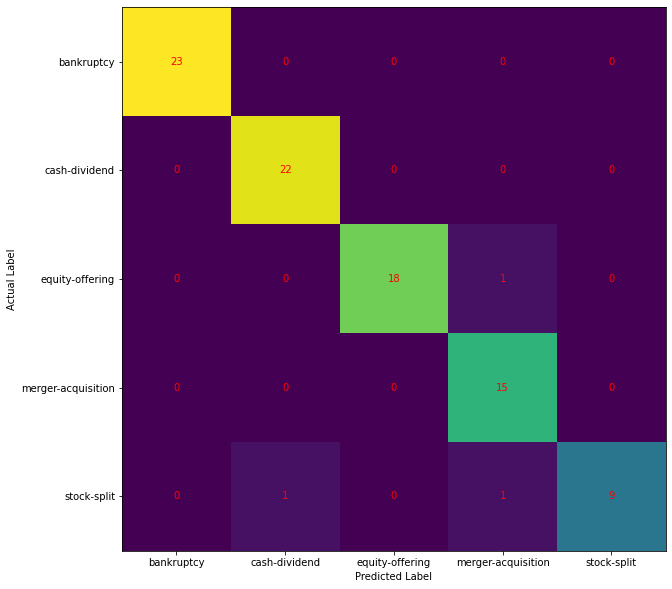

In [17]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(c_matrix)

ax.set_ylabel("Actual Label")
ax.set_xlabel("Predicted Label")
labels = tuple(label_encoder.inverse_transform([0, 1, 2, 3, 4]))
ax.xaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
ax.yaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
for i in range(len(labels)):  # ref: (https://realpython.com/logistic-regression-python/)
    for j in range(len(labels)):
        ax.text(j, i, c_matrix[i, j], ha='center', va='center', color='red')

In [18]:
# Calculate key metrics
precision = precision_score(y_test_labels, y_pred, average="weighted")
recall = recall_score(y_test_labels, y_pred, average="weighted")
f1 = f1_score(y_test_labels, y_pred, average="weighted")

print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")

Precision Score: 0.9697641375390735
Recall Score: 0.9666666666666667
F1 Score: 0.9662233066399732
